In [8]:
from torch import nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn.modules.utils import _pair, _quadruple, _ntuple
from torch.nn.common_types import _size_4_t
import matplotlib.pyplot as plt
import xesmf as xe
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar

In [4]:
torch.__version__

'1.7.0'

In [4]:
ds_e = xr.open_zarr("/datadrive/era5/all_hist_global_zarr")
ds_e

,Array,Chunk
Bytes,15.91 GB,1.04 MB
Shape,"(1, 15341, 360, 720)","(1, 1, 360, 720)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.91 GB,1.04 MB
Shape,"(1, 15341, 360, 720)","(1, 1, 360, 720)"
Count,15342 Tasks,15341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [20]:
ds_h = xr.open_zarr("/datadrive/hadgem3/nat_hist_zarr").isel(run=slice(0,1))
ds_h

,Array,Chunk
Bytes,21.77 GB,1.12 MB
Shape,"(1, 19440, 2, 324, 432)","(1, 1, 2, 324, 432)"
Count,213841 Tasks,19440 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,21.77 GB,1.12 MB
Shape,"(1, 19440, 2, 324, 432)","(1, 1, 2, 324, 432)"
Count,213841 Tasks,19440 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
ds_e.z500.isel(time=0, run=0).load()

<xarray.DataArray 'z500' (lat: 360, lon: 720)>
array([[5244.9087, 5244.9336, 5244.959 , ..., 5244.8315, 5244.858 ,
        5244.883 ],
       [5245.3647, 5245.4326, 5245.502 , ..., 5245.1606, 5245.228 ,
        5245.2974],
       [5244.815 , 5244.9224, 5245.0312, ..., 5244.4966, 5244.601 ,
        5244.708 ],
       ...,
       [5125.848 , 5125.5205, 5125.192 , ..., 5126.838 , 5126.5073,
        5126.1772],
       [5134.6   , 5134.4175, 5134.2314, ..., 5135.1597, 5134.9727,
        5134.787 ],
       [5143.003 , 5142.965 , 5142.927 , ..., 5143.119 , 5143.0806,
        5143.042 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.625 -89.125 -88.625 ... 88.875 89.375 89.875
  * lon      (lon) float32 0.125 0.625 1.125 1.625 ... 358.625 359.125 359.625
    run      int64 1
    time     datetime64[ns] 1979-01-01

In [11]:
ds_h.z500.isel(time=10, run=0, height=2).load()

<xarray.DataArray 'z500' (lat: 324, lon: 432)>
array([[5253.0923, 5253.051 , 5253.01  , ..., 5253.219 , 5253.179 ,
        5253.0723],
       [5254.183 , 5254.106 , 5254.0273, ..., 5254.412 , 5254.3345,
        5254.194 ],
       [5253.752 , 5253.656 , 5253.5586, ..., 5254.0405, 5253.9424,
        5253.7812],
       ...,
       [5112.1655, 5112.1743, 5112.1865, ..., 5112.176 , 5112.167 ,
        5112.101 ],
       [5122.6245, 5122.6343, 5122.647 , ..., 5122.6216, 5122.6206,
        5122.5576],
       [5132.897 , 5132.9033, 5132.909 , ..., 5132.8926, 5132.893 ,
        5132.8306]], dtype=float32)
Coordinates:
    height   float32 5500.0
  * lat      (lat) float32 -89.72222 -89.166664 -88.611115 ... 89.16667 89.72223
  * lon      (lon) float32 0.41666666 1.25 2.0833333 ... 358.75 359.5833
    run      int64 1
    time     object 1960-01-11 12:00:00

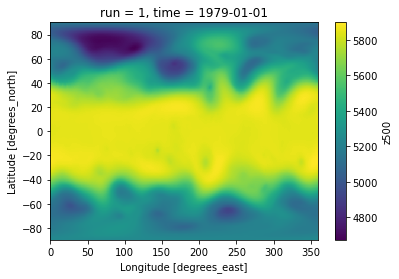

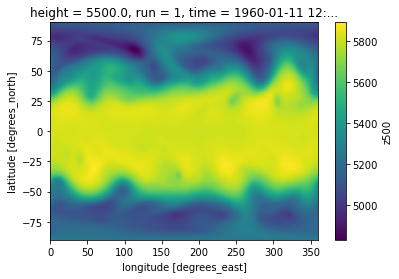

In [13]:
ds_e.z500.isel(time=0, run=0).plot()
plt.figure()
ds_h.z500.isel(time=10, run=0, height=2).plot()

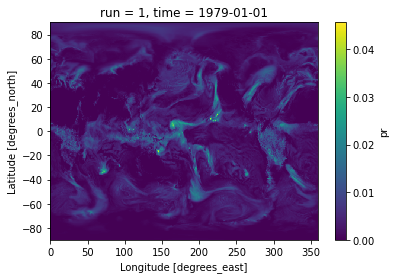

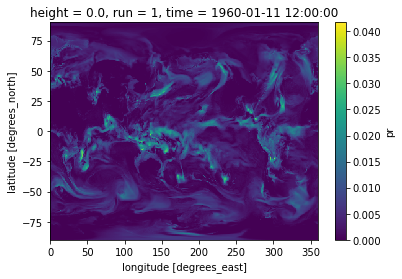

In [27]:
def pr_proc(da):
    return da**0.5
pr_proc(ds_e.pr.isel(time=0, run=0)).plot()
plt.figure()
pr_proc(ds_h.pr.isel(time=10, run=0, height=0)).plot()

In [21]:
de_z_mean = ds_e.z500.mean(dim=('time', 'run')).compute()

In [24]:
with ProgressBar(dt=10):
    dh_z_mean = ds_h.z500.isel(height=2).mean(dim=('time', 'run')).compute()

[########################################] | 100% Completed |  1min 20.1s


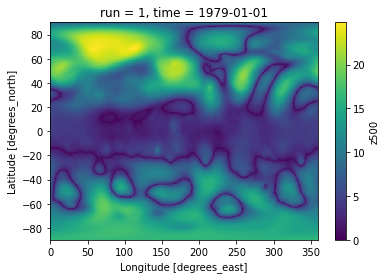

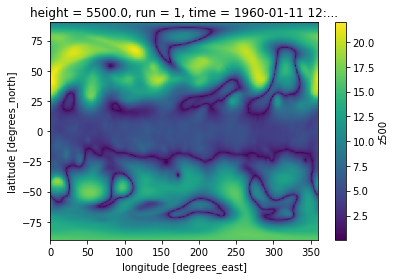

In [29]:
def z500_proc(da):
    return np.abs(da)**0.5
z500_proc(ds_e.z500.isel(time=0, run=0) - de_z_mean).plot()
plt.figure()
z500_proc(ds_h.z500.isel(time=10, run=0, height=2) - dh_z_mean).plot()

In [130]:
with ProgressBar(dt=10):
    dh_pr_mean = ds_h.pr.isel(height=0).mean(dim=('time', 'run')).compute()

[########################################] | 100% Completed |  1min 40.1s


In [32]:
with ProgressBar(dt=10):
    de_pr_mean = ds_e.pr.mean(dim=('time', 'run')).compute()

[########################################] | 100% Completed |  1min 10.1s


In [64]:
np.diff(dh_pr_mean.lat).mean()

0.5555556

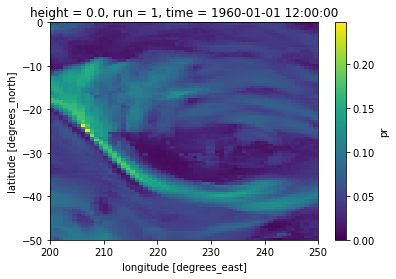

In [72]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-50,0), lon=slice(200, 250))
(ds_h.pr.isel(time=0, run=0, height=0)**0.25).sel(sel).plot(**kwargs)

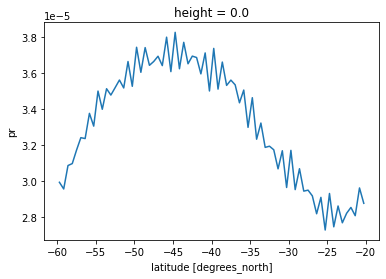

In [131]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
(dh_pr_mean**1).sel(sel).mean(dim=('lon')).plot(**kwargs)

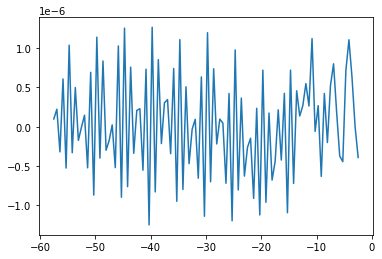

In [132]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=9
plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), w)

)

In [ ]:
(dh_pr_mean**0.25).sel(sel).mean(dim=('lon')).plot(**kwargs)

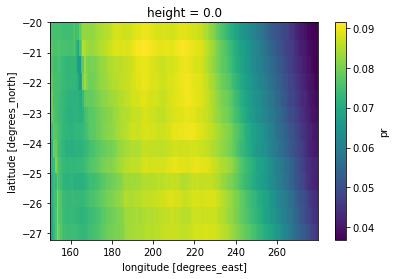

In [82]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-27,-20), lon=slice(150, 280))
(dh_pr_mean**0.25).sel(sel).plot(**kwargs)

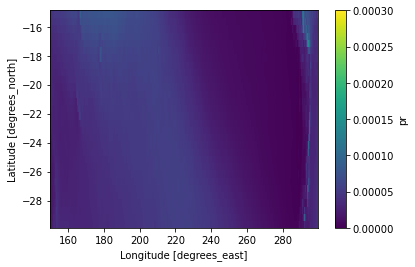

In [58]:
de_pr_mean.sel(sel).plot(**kwargs)

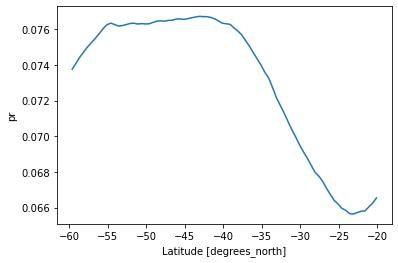

In [84]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
(de_pr_mean**0.25).sel(sel).mean(dim=('lon')).plot(**kwargs)

## check partial zarr dataset and fresh download from source

In [9]:
with ProgressBar(dt=10):
    dh_pr_mean = ds_h.pr.isel(height=0).sel(time=slice("2000-01-01", "2009-12-30")).mean(dim=('time', 'run')).compute()

[########################################] | 100% Completed | 20.0s


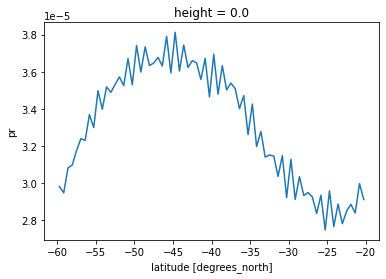

In [10]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
(dh_pr_mean**1).sel(sel).mean(dim=('lon')).plot(**kwargs)

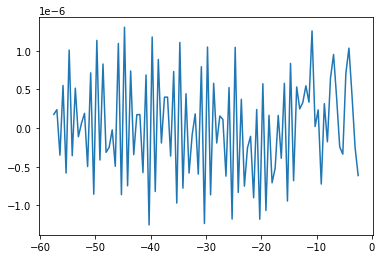

In [11]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=9
plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), w)

)

In [12]:
ds_h = xr.open_dataset("/datadrive/tmp/pr_Aday_HadGEM3-A-N216_Nat-Hist_CMIP5-est1_v1-0_r1i1p15_20000101-20091230.nc")

In [15]:
with ProgressBar(dt=10):
    dh_pr_mean = ds_h.pr.isel(height=0).mean(dim=('time')).compute()

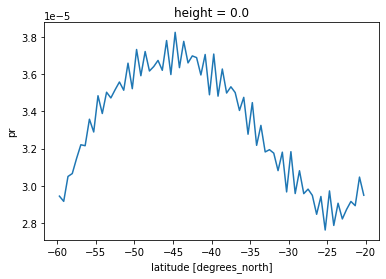

In [16]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
(dh_pr_mean**1).sel(sel).mean(dim=('lon')).plot(**kwargs)

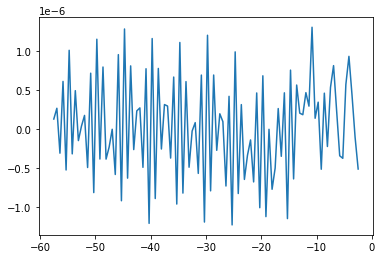

In [17]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
w=9
plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), w)

)

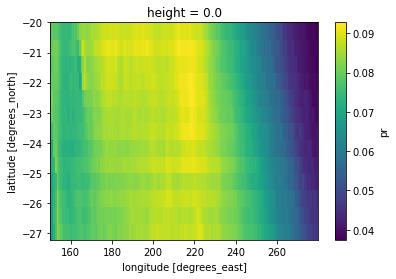

In [18]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-27,-20), lon=slice(150, 280))
(dh_pr_mean**0.25).sel(sel).plot(**kwargs)

## check other variables

In [23]:
ds_h = xr.open_zarr("/datadrive/hadgem3/all_hist_zarr").isel(run=slice(0,1))
ds_h

,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,32.65 GB,559.87 kB
Shape,"(1, 19440, 3, 324, 432)","(1, 1, 1, 324, 432)"
Count,58321 Tasks,58320 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [27]:
with ProgressBar(dt=10):
    dh_mean = ds_h.sel(time=slice("2000-01-01", "2009-12-30")).mean(dim=('time', 'run', 'height')).compute()

[########################################] | 100% Completed |  2min 40.2s


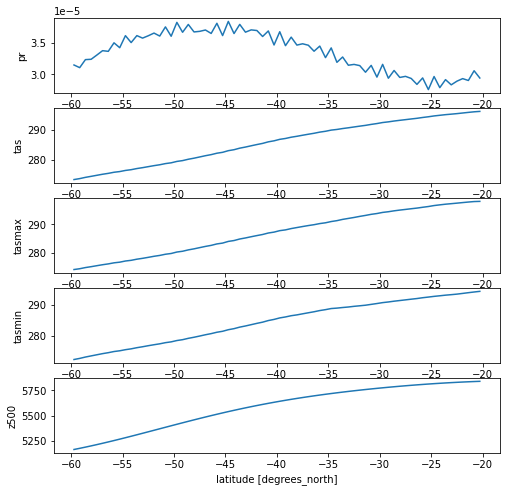

In [34]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
fig, axes = plt.subplots(len(dh_mean.keys()), 1, figsize=(8, 8))
for k, ax in zip(dh_mean.keys(), axes):
    (dh_mean[k]**1).sel(sel).mean(dim=('lon')).plot(ax=ax)

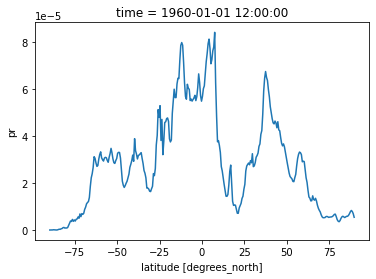

In [35]:
ds_h.pr.isel(time=0).mean(dim=('run', 'height', 'lon')).plot()

In [37]:
ds_h.pr.isel(time=0)

<xarray.DataArray 'pr' (run: 1, height: 3, lat: 324, lon: 432)>
dask.array<getitem, shape=(1, 3, 324, 432), dtype=float32, chunksize=(1, 1, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) float32 0.0 2.0 5500.0
  * lat      (lat) float32 -89.72222 -89.166664 -88.611115 ... 89.16667 89.72223
  * lon      (lon) float32 0.41666666 1.25 2.0833333 ... 358.75 359.5833
  * run      (run) int64 1
    time     object 1960-01-01 12:00:00
Attributes:
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    cell_methods:      time: mean
    comment:           at surface; includes both liquid and solid phases from...
    history:           2015-06-02T15:53:57 out-of-bounds adjustments: (-1e-07...
    long_name:         Precipitation
    original_name:     mo: m01s05i216
    standard_name:     precipitation_flux
    units:             kg m-2 s-1

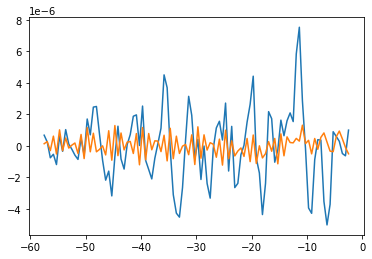

In [59]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

w=9

days=5

ds_ = ds_h.pr.isel(time=slice(0, days*10, 10), run=0, height=0).mean(dim='time')
plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average(ds_.sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average(ds_.sel(sel).mean(dim=('lon')), w)

)


plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), w)

)

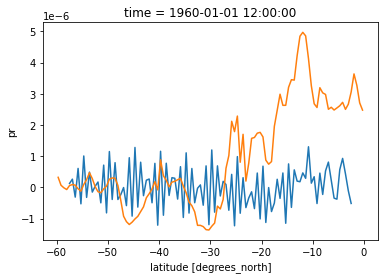

In [55]:
sel = dict(lat=slice(-60,0))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

w=9

plt.plot(
    dh_pr_mean.lat.sel(sel).values[w//2:-w//2+1],
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average((dh_pr_mean**1).sel(sel).mean(dim=('lon')), w)

)

(ds_h.pr.isel(time=0).sel(sel)/10 - 3e-6).mean(dim=('run', 'height', 'lon')).plot()

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

In [65]:
cosine_similarity(np.array([[1,1,1]]), np.array([[2,2,2]]))

array([[1.]])

In [72]:
w = 9

ds_ = ds_h.pr.isel(run=0, height=0).mean(dim='time')

signal = (
    moving_average(ds_.sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
    moving_average(ds_.sel(sel).mean(dim=('lon')), w)
)[np.newaxis]

array([[0.23797965]])

In [80]:
import progressbar

days = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
repeats = [1024//d for d in days]
sim = []
with progressbar.ProgressBar(max_value=len(days)) as bar:
    bar.update(0)
    i = 0
    for d, r in zip(days, repeats):
        selected = np.random.choice(np.arange(len(ds_h.time)), size=d, replace=False) 
        ds_ = ds_h.pr.isel(time=selected, run=0, height=0).mean(dim='time')
        cs = 0
        for rep in range(r):
            this_signal = (
                moving_average(ds_.sel(sel).mean(dim=('lon')), 1)[w//2:-w//2+1] - 
                moving_average(ds_.sel(sel).mean(dim=('lon')), w)
            )[np.newaxis]
            cs+=cosine_similarity(signal, this_signal)[0,0]
        sim.append(cs/r)
        i+=1
        bar.update(i)

100% (11 of 11) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


Text(0.5, 0, 'days')

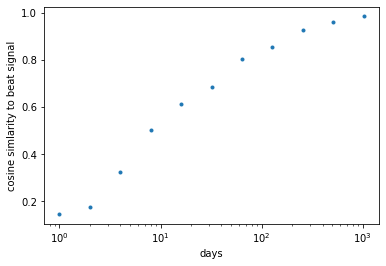

In [81]:
plt.semilogx(days, sim, linestyle='', marker='.')
plt.ylabel("cosine simlarity to beat signal")
plt.xlabel('days')

## check other datasets

In [82]:
ds_c = xr.open_zarr("/datadrive/cam5/nat_hist_zarr").isel(run=slice(0,1))
ds_c

,Array,Chunk
Bytes,9.12 GB,442.37 kB
Shape,"(1, 20621, 2, 192, 288)","(1, 1, 2, 192, 288)"
Count,206211 Tasks,20621 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,9.12 GB,442.37 kB
Shape,"(1, 20621, 2, 192, 288)","(1, 1, 2, 192, 288)"
Count,206211 Tasks,20621 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [83]:
with ProgressBar(dt=10):
    dc_pr_mean = ds_c.pr.isel(height=0).sel(time=slice("2000-01-01", "2009-12-30")).mean(dim=('time', 'run')).compute()

[########################################] | 100% Completed | 20.0s


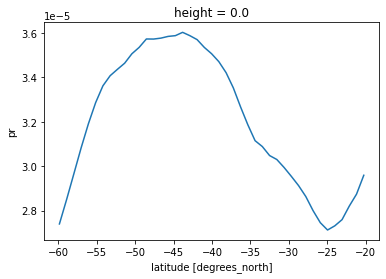

In [84]:
kwargs = {}#dict(vmin=0, vmax=0.0003)
sel = dict(lat=slice(-60,-20))#dict(lat=slice(-27,-20), lon=slice(150, 280))
(dc_pr_mean**1).sel(sel).mean(dim=('lon')).plot(**kwargs)